In [335]:
%matplotlib inline

import matplotlib 
import numpy as np
import pandas as pd
import os, sys, time, pickle, copy
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    

from scipy import optimize

import cv2 

matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=14)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)


matplotlib.rc('figure', figsize=(12, 9))


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0')

# 푸리에 급수
주기 $T$ 를 갖는 연속함수 $f(t)$ 는 다음과 같은 푸리에 급수로 표현 할 수 있다.
$$
\begin{aligned}
f(t) &= \sum_{n=-\infty}^{\infty} F_n \exp \left(\dfrac{i 2\pi n}{T}t\right)\,,\\
F_n &= \dfrac{1}{T}\int_{-T/2}^{T/2} f(t) \exp \left(-\dfrac{i2\pi n }{T}t \right)\, dt\,, \qquad n\in \mathbb{Z}
\end{aligned}
$$


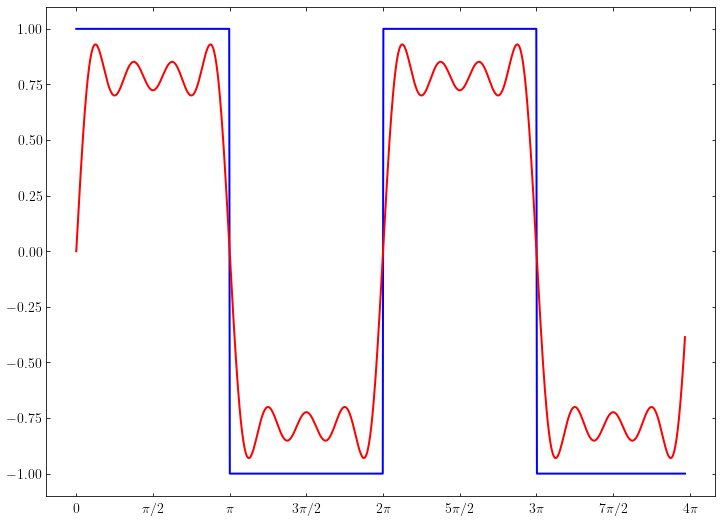

In [336]:
ax = plt.gca()
x=np.linspace(0, 4.0*np.pi-0.1, 1000)
f1=np.ones(x.shape)
f1[np.fmod(x, 2*np.pi)>np.pi]=-1
plt.plot(x, f1, "b-", lw=2)
f2=np.sin(x)+1./3 *np.sin(3*x)+1./5 *np.sin(5*x)+1./7*np.sin(7*x)
plt.plot(x, f2, "r-", lw=2)
ax.set_xticks(np.arange(0, 4*np.pi+0.01, np.pi/2))
labels = ['$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$',
          r'$5\pi/2$', r'$3\pi$', r'$7\pi/2$', r'$4\pi$']
ax.set_xticklabels(labels)
print("")

# 푸리에 변환

## 1차원 푸리에 변환
$$
\begin{aligned}
F(\mu) &= \mathfrak{I} \left[f(t)\right]=\int_{-\infty}^{\infty} f(t)e^{-2i\pi \mu t}\, dt\,, \\
f (t) &= \mathfrak{I}^{-1} \left[F(\mu)\right] = \int_{-\infty}^{\infty} F(\mu) e^{2i \pi \mu t} \, d\mu
\end{aligned}
$$



## 2차원 푸리에 변환
$$
\begin{aligned}
F(u,\,v) &= \mathfrak{I} \left[f(x,\,y)\right]=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} f(x,\,y)e^{-2i\pi (ux+vy)}\, dxdy\,, \\
f (x,\,y) &= \mathfrak{I}^{-1} \left[F(u,\,v)\right] = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} F(\mu) e^{2i \pi (ux+vy)} \, dudv
\end{aligned}
$$


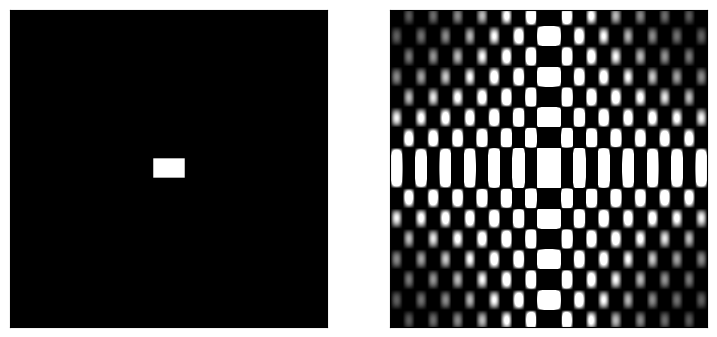

In [95]:
U, V = 1.0, 0.6
x0, y0 = np.linspace(-5, 5, 1101), np.linspace(-5, 5, 1101)
x, y = np.meshgrid(x0, y0)
img1 = ((np.abs(x)<U/2)&(np.abs(y)<V/2)).astype(np.float64)

u0, v0 = np.linspace(-13, 13, 302), np.linspace(-13, 13, 302)
u, v = np.meshgrid(u0, v0)
img2 = U*V*np.sin(np.pi*U*u)/(np.pi*U*u)*np.sin(np.pi*V*v)/(np.pi*V*v)

fig1 = plt.figure(figsize=(9,5), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2= fig1.add_subplot(121), fig1.add_subplot(122)
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2*100, cmap='gray', vmin=0.0, vmax=0.2)

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 푸리에 변환의 몇가지 수학적 성질

### 1. Similarity

$$
f (x,\,y) \iff F(u,\,v) \implies f(ax,\,by) =\dfrac{1}{ab} F\left(\dfrac{u}{a},\, \dfrac{v}{b}\right)
$$


---

$$
\begin{aligned}
\mathfrak{I}[f(ax,\,by)] &= \iint f(ax,\, by) e^{-2i\pi (ux+vy)}\,dxdy \qquad & t=ax,\, s=by\\
&= \dfrac{1}{ab} \iint f(s,\,t) e^{-2i \pi (ut/a+vs/b)}\, dtds \\
&= \dfrac{1}{ab} F \left(\dfrac{u}{a},\, \dfrac{v}{b} \right)
\end{aligned}
$$


#### 2. Shift Theorem

$$
f(x,\,y) \iff F(u,\,v) \implies f(x-a,\, y-b) \iff \exp (i2\pi (au+bv)) F(u,\,v)
$$

---

$$
\begin{aligned}
\mathfrak{I}[f(x-a,\, y-b) ]&= \iint f(x-a,\, y-b) e^{-2i\pi (ux+vy)} \,dxdy \qquad & t=x-a,\, s=y-b\\
&=\iint f(t,\,s) e^{-2i\pi (ux+vy)} e^{2i\pi (au+bv)} \, dxdy \\
&= e^{2i\pi (au+bv)}F(u,\,v)
\end{aligned}
$$


#### 3. 도함수의 푸리에 변환

$$
\mathfrak{I}[f(x)] = F(u)   \implies \mathfrak{I}\left[ \dfrac{d^kf}{dx^k} \right] =( 2i\pi u)^k F(u) 
$$

---
$k=1$ 인 경우만 보이면 나머지는 쉽게 일반화 된다. $\mathfrak{I}[f(x)]=F(u)$ 이면 $f(x)=\displaystyle \int_{-\infty}^{\infty} F(u)e^{2i\pi ux}\, du$ 이므로

$$
f'(x) =  \int_{-\infty}^{\infty}(2i\pi u) F(u)e^{2i \pi ux} \, du
$$

이다. 따라서 

$$
\mathfrak{I}[f'(x)] = (2i\pi u) F(u)
$$
이다.

## 용어

$F(u,\,v)$ 를 극좌표 형태로 다음과 같이 표현 할 수 있다. 

$$
F(u,\,v) = |F(u,\,v)| e^{i\Phi(u,\,v)}
$$


이 때 $|F(u,\,v)|$ 를 **푸리에 스펙트럼 (Fourier spectrum)** 이라 하고, $\Phi(u,\,v)$ 를 **위상 (phase)** 이라 한다. 또한 $P(u,\,v) =|F(u,\,v)|^2$ 를 **푸리에 파워 스펙트럼 (Fourier power spectrum)** 이라 한다.

## 평행이동과 회전변환의 푸리에 변환

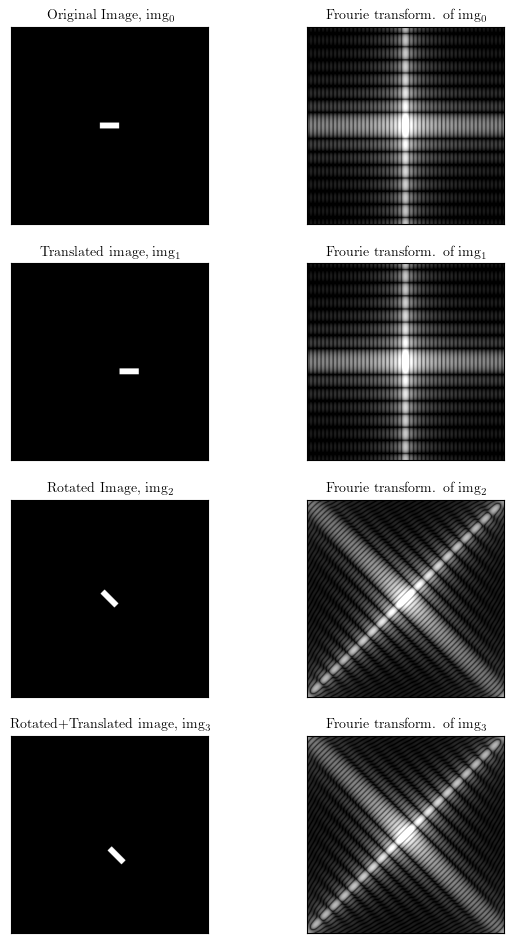

In [485]:
# 아래에서 소개할 numpy 의 fft module 을 사용하였음.
import numpy.fft
fig1 = plt.figure(figsize=(7,12), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = fig1.add_subplot(421), fig1.add_subplot(422),\
    fig1.add_subplot(423), fig1.add_subplot(424), fig1.add_subplot(425), fig1.add_subplot(426), \
    fig1.add_subplot(427), fig1.add_subplot(428),

U, V = 1., 0.3
x0, y0 = np.linspace(-5, 5, 501), np.linspace(-5, 5, 501)
x, y = np.meshgrid(x0, y0)
img1 = ((np.abs(x)<U/2)&(np.abs(y)<V/2)).astype(np.float64)
ax1.imshow(img1, cmap='gray')
ax1.set_title("Original Image, img$_0$", size=10)
u0, v0 = np.linspace(-13, 13, 302), np.linspace(-13, 13, 302)
u, v = np.meshgrid(u0, v0)
#img2 = U*V*np.sin(np.pi*U*u)/(np.pi*U*u)*np.sin(np.pi*V*v)/(np.pi*V*v)
img2 = np.fft.fftshift(np.fft.fft2(img1))
ax2.imshow(np.log(1.0+np.abs(img2)), cmap='gray', vmin=0.2, vmax=5)
ax2.set_title("Frourie transform. of img$_0$", size=10)

# Transilation of image
img3 = ((np.abs(x-1)<U/2)&(np.abs(y-0.5)<V/2)).astype(np.float64)
ax3.imshow(img3, cmap='gray')
ax3.set_title("Translated image, img$_1$", size=10)
img4 = np.fft.fftshift(np.fft.fft2(img3))
ax4.imshow(np.log(1.0+np.abs(img4)), cmap='gray', vmin=0.2, vmax=5.)
ax4.set_title("Frourie transform. of img$_1$", size=10)


# Rotation of image
x1 = x*np.cos(np.pi/4)+y*np.sin(np.pi/4)
y1 = -x*np.sin(np.pi/4)+y*np.cos(np.pi/4)
img5 = ((np.abs(x1)<U/2)&(np.abs(y1)<V/2)).astype(np.float64)
ax5.imshow(img5, cmap='gray')
ax5.set_title("Rotated Image, img$_2$", size=10)
img6 = np.fft.fftshift(np.fft.fft2(img5))
ax6.imshow(np.log(1.0+np.abs(img6)), cmap='gray', vmin=0.2, vmax=5.)
ax6.set_title("Frourie transform. of img$_2$", size=10)

# Rotated and translated image
img7 = ((np.abs(x1-1)<U/2)&(np.abs(y1-0.5)<V/2)).astype(np.float64)
ax7.imshow(img7, cmap='gray')
ax7.set_title("Rotated+Translated image, img$_3$", size=10)
img8 = np.fft.fftshift(np.fft.fft2(img7))
ax8.imshow(np.log(1.0+np.abs(img8)), cmap='gray', vmin=0.2, vmax=5.)
ax8.set_title("Frourie transform. of img$_3$", size=10)






for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 주기적 임펄스 함수의 푸리에 변환

단위 임펄스 함수(디렉 델타 함수)가 $T$ 를 주기로 반복되는 함수를 주기적 임펄스 함수라 하며 이를 $S_T(t)$ 라 하자. 이는 주기함수이므로 푸리에 급수로 표현 할 수 있으며 다음과 같다. 

$$
\begin{aligned}
S_T(t) &= \sum_{n=-\infty}^{\infty} \delta \left(t-nT \right) \,, \\
&=\dfrac{1}{T} \sum_{n=-\infty}^{\infty} \exp \left( \dfrac{-i2n\pi t}{T}\right)
\end{aligned}
$$

단일 임펄스 함수 $\delta(\mu-\mu_0)$ 에 대한 푸리에 변환은 다음과 같다.

$$
\mathfrak{I}[\delta (\mu-\mu_0)] = \int_{-\infty}^{\infty} \delta (\mu-\mu_0) e^{2i\pi \mu t}\, d\mu = e^{2i\pi \mu_0 t}
$$

따라서,

$$
\mathfrak{I}^{-1} \left[ \delta \left( \mu-\dfrac{n}{T} \right) \right] = \exp \left( \dfrac{2in\pi t}{t} \right) \iff \mathfrak{I}\left[  \exp \left( \dfrac{2in\pi t}{t} \right) \right] =  \delta \left( \mu-\dfrac{n}{T} \right)
$$

이다. 이를 이용하면 $s_T(t)$ 의 푸리에 변환식 $S(\mu)=\mathfrak{I}[s_N(t)]$ 를 계산 할 수 있으며 다음과 같다.

$$
S (\mu) = \mathfrak{I}\left[\dfrac{1}{T} \sum_{n=-\infty}^{\infty} \exp \left( \dfrac{-i2n\pi t}{T}\right)\right] = \dfrac{1}{T} \sum_{n=-\infty}^{\infty} \mathfrak{I}\left[ \exp \left( \dfrac{-i2n\pi t}{T}\right) \right] = \dfrac{1}{T} \sum_{n=-\infty}^{\infty} \delta \left(\mu - \dfrac{n}{T}\right)
$$




## Convolution 의 푸리에 변환

두 함수 $f(t),\, g(t)$ 의 convolution  $f(t) \otimes g(t)$ 은 다음과 같이 정의된다.

$$
f(t) \otimes g(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t-\tau) \, d\tau
$$

$F(\mu)= \mathfrak{I}[f(t)],\, G(\mu)=\mathfrak{I}[g(t)]$ 라 할 때, $f(t)\otimes g(t)$ 의 푸리에 변환을 구하면,

$$
\begin{aligned}
\mathfrak{I}[f(t) \otimes g(t)] &= \int_{-\infty}^{\infty} \left[ \int_{-\infty}^{\infty} f(\tau)g(t-\tau) d\tau\right] e^{-2in\pi \mu t}\, dt \\
&= \int_{-\infty}^{\infty}f(\tau) \left[  \int_{-\infty}^{\infty} g(t-\tau)e^{-2in \pi \mu t}\, dt\right] \,d\tau \\
&= \int_{-\infty}^{\infty} f(\tau) G(\mu)e^{-2in \pi \mu \tau} \, d\tau \\
&= F(\mu)G(\mu)
\end{aligned}
$$


즉 합성곱의 푸리에 변환은 푸리에 변환의 곱이다. 이를 응용하면 두 함수의 곱의 푸리에변환은 합성곱이 됨을 보일 수 있다. 즉,

$$
\mathfrak{I}[f(t)g(t)]=F(\mu)\otimes G(\mu)
$$

가 된다.

# 푸리에 변환과 샘플링

임의의 연속함수 $f(t)$ 를 $T$ 를 주기로 샘플링 하였다고 하자. 그렇다면 이 샘플링 $\tilde{f}(t)$ 은 다음과 같은 식으로 표현 할 수 있다.

$$
\tilde{f}(t) = \sum_{n=-\infty}^{\infty} f(t) \delta (t-nT)
$$

이 때 $\mathfrak{I}[f(t)]= F(\mu),\, \mathfrak{I}[s_T(t)]= S(\mu)$ 라 하자 $\displaystyle S(\mu)=\dfrac{1}{T} \sum_{n=-\infty}^{\infty} \delta \left( \mu - \dfrac{n}{T}\right)$ 임은 알고 있다. 그렇다면 $\tilde{F}(\mu)=\mathfrak{I}\left[\tilde{f}(t) \right]$ 를 구하면,

$$
\begin{aligned}
\tilde{F}(\mu) & = F(\mu)\otimes S(\mu) = \int_{-\infty}^{\infty} F(\tau)S(\mu-\tau)\, d\tau \\
&= \dfrac{1}{T} \sum_{n=-\infty}^{\infty}\int_{-\infty} F(\tau) \delta \left(\mu-\tau-\dfrac{n}{T}\right)\, d\tau \\
&= \dfrac{1}{T}\sum_{n=-\infty}^{\infty} F\left( \mu - \dfrac{n}{T} \right)
\end{aligned}
$$

이다. 즉, 주기 $T$ 로 샘플링된 연속 함수 $f(t)$의 함수의 푸리에 변환은 원래 함수의 푸리에 변환 $F(\mu)$ 를 주기 $1/T$ 를 갖는 임펄스 함수로 바꾼 형태임을 알 수 있다.


# 이산 푸리에 변환 (Discrete Fourier Transformation, DFT)

1차원 공간상의 함수 $f$ 에 대해 $k$ 번째 에서의 값을 $f_k$ 라 하자. 그리고 이 수열을 $\mathbf{f}$ 라 하자. 즉,
$$
\mathbf{f}=(f_0,\ldots,\,f_{N-1})
$$

이다.

우리는 여기서 한가지 가정을 하게 되는데 $f$ 이 주기 $N$ 을 갖는다는 것이다. 즉 $f_{k+N}=f_k$ 이다. 이 때 $\mathfrak{I}[\mathbf{f}]=\mathbf{F}=[F_1,\ldots,\,F_{N-1}]$ 의 $F_\mu$ 는 다음과 같이 구할 수 있다.

$$
F_\mu = \dfrac{1}{N}\int_{0}^{N-1} f(t) \exp \left(-\dfrac{i2\pi \mu }{N}t \right)\, dt = \dfrac{1}{N} \sum_{k=0}^{N-1} f_i \exp\left(-\dfrac{i2\pi \mu }{N} k \right)
$$

또한 $f_k$ 는 다음과 같이 표현 할 수 있다.

$$
f_k = \sum_{\mu=0}^{N-1} F_\mu \exp \left(-\dfrac{i2\pi k\mu }{N} \right)
$$


## 이차원 이산 푸리에 변환

$$
\begin{aligned}
F_{uv} &= \dfrac{1}{MN} \sum_{j=0}^{M-1}\sum_{k=0}^{N-1} f_{jk} \exp \left[-2i\pi \left(\dfrac{ju}{M}+\dfrac{kv}{N}\right)\right] \\
f_{jk} &=  \sum_{j=0}^{M-1}\sum_{k=0}^{N-1} F_{uv} \exp \left[2i\pi \left(\dfrac{ju}{M}+\dfrac{kv}{N}\right)\right]
\end{aligned}
$$

## DFT in python

- numpy 의 fft 모듈에 대한 설명은 다음을 참조하라

https://numpy.org/doc/stable/reference/routines.fft.html

- cv2 for python 의 fft 모듈에 대한 설명은 다음을 참조하라

https://docs.opencv.org/master/de/dbc/tutorial_py_fourier_transform.html

여기서는 numpy의 fft와 opencv2 for python 의 fft를 둘 다 설명하고 있다.

- pytorch 의 fft 모듈에 대한 설명은 다음을 참고하라.

https://pytorch.org/docs/stable/fft.html


In [226]:
# matplab, numpy 의 dft 함수와 교수님의 수식에 차이가 있음, dft에서 전체 sample 갯수를 나누어 주는것을 dft에서
# 하는지, idft 단계에서 하는지가 문제인다, 권교수님의 수식에서는 dft 단계에서 하지만 matlab이나 python 에서는 idft
# 단계에서 수행함.
# 아래 코드는 matlab, numpy 에서의 fft, ifft를 구현해 본 것임. 

def mydft1(arr):
    N = len(arr)
    x, u = np.mat(np.arange(N)).T, np.mat(np.arange(N))
    return np.array(arr@np.exp(-2*np.pi*(1j)*(x@u)/N)).reshape(arr.shape)

def myidft1(arr):
    N = len(arr)
    x, u = np.mat(np.arange(N)).T, np.mat(np.arange(N))
    return 1./N*np.array(arr@np.exp(2*np.pi*(1j)*(x@u)/N)).reshape(arr.shape)

In [232]:
# 권석준 교수님 강의록 4장 25페이지 예제

x=np.array([2,3,4,5,6,7,8,9,1])
x1=(-1)**x*x
X=np.fft.fft(x)
X1=np.fft.fft(x1)
Y=mydft1(x)
Y1=mydft1(x1)

In [233]:
X, X1, Y, Y1

(array([ 45.        +0.j        , -11.39439999+6.5785599j ,
         -6.0628336 -3.50037861j,   0.        -5.19615242j,
          3.95723359-2.28470988j,   3.95723359+2.28470988j,
          0.        +5.19615242j,  -6.0628336 +3.50037861j,
        -11.39439999-6.5785599j ]),
 array([-5.         +0.j        , -2.49272604 -4.70485718j,
         3.73782595 -5.37873768j, 10.         +1.73205081j,
         0.25490009+33.10111025j,  0.25490009-33.10111025j,
        10.         -1.73205081j,  3.73782595 +5.37873768j,
        -2.49272604 +4.70485718j]),
 array([ 4.50000000e+01+0.j        , -1.13944000e+01+6.5785599j ,
        -6.06283360e+00-3.50037861j,  1.99840144e-15-5.19615242j,
         3.95723359e+00-2.28470988j,  3.95723359e+00+2.28470988j,
        -2.16493490e-15+5.19615242j, -6.06283360e+00+3.50037861j,
        -1.13944000e+01-6.5785599j ]),
 array([-5.         +0.j        , -2.49272604 -4.70485718j,
         3.73782595 -5.37873768j, 10.         +1.73205081j,
         0.25490009+33.10

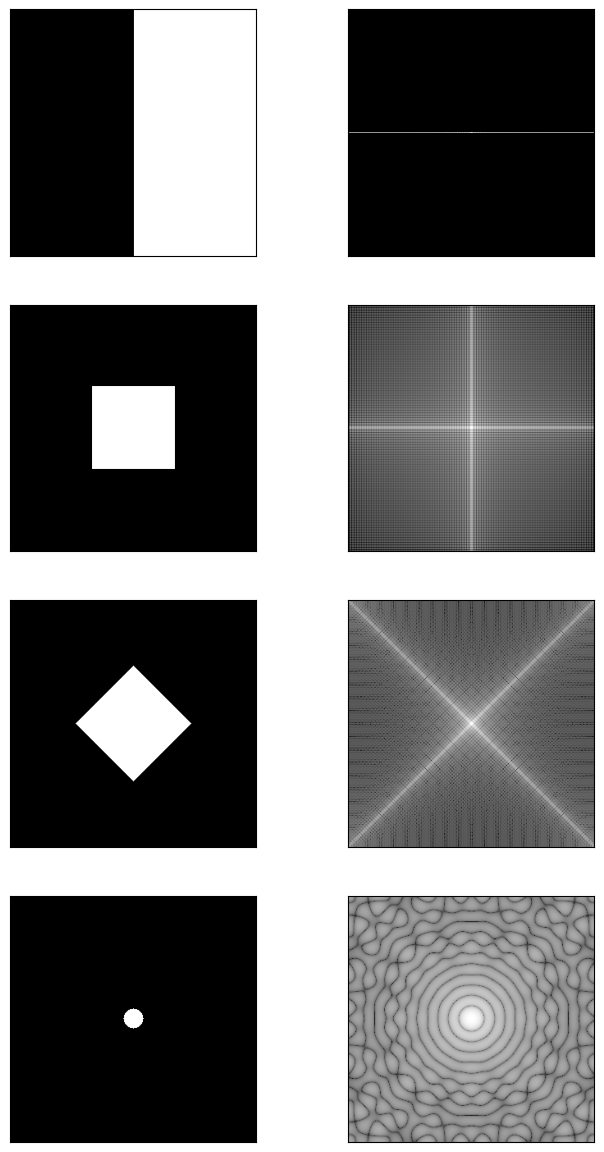

In [298]:
fig1 = plt.figure(figsize=(8,15), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = fig1.add_subplot(421), fig1.add_subplot(422),\
    fig1.add_subplot(423), fig1.add_subplot(424), fig1.add_subplot(425), fig1.add_subplot(426), \
    fig1.add_subplot(427), fig1.add_subplot(428),

N=301
X0, Y0 = np.meshgrid(np.arange(N), np.arange(N))
X, Y = X0-int(N/2), Y0-int(N/2)
im1=np.zeros((N, N))
im1[np.where(X>0)]=255
im2 = np.fft.fftshift(np.fft.fft2(im1))
ax1.imshow(im1, cmap='gray')
ax2.imshow(np.log(1.+np.abs(im2)), cmap='gray')

im3 = np.zeros((N,N))
im3[(np.abs(X)<N/6)&(np.abs(Y)<N/6)]=255
im4 = np.fft.fftshift(np.fft.fft2(im3))
ax3.imshow(im3, cmap='gray')
ax4.imshow(np.log(1.+np.abs(im4)), cmap='gray')


Xr = (X)*np.cos(np.pi/4)+(Y)*np.sin(np.pi/4)
Yr = -(X)*np.sin(np.pi/4)+(Y)*np.cos(np.pi/4)
im5 = np.zeros((N,N))
im5[(np.abs(Xr)<N/6)&(np.abs(Yr)<N/6)]=255
im6 = np.fft.fftshift(np.fft.fft2(im5))

ax5.imshow(im5, cmap='gray')
ax6.imshow(np.log(1.+np.abs(im6)), cmap='gray')


im7 = np.zeros((N,N))
im7[np.abs(X**2+Y**2)<(N/25)**2]=255
im8 = np.fft.fftshift(np.fft.fft2(im7))
ax7.imshow(im7, cmap='gray')
ax8.imshow(np.log(1.+np.abs(im8)), cmap='gray')

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    

plt.show()

## Ideal Low Pass Filtering

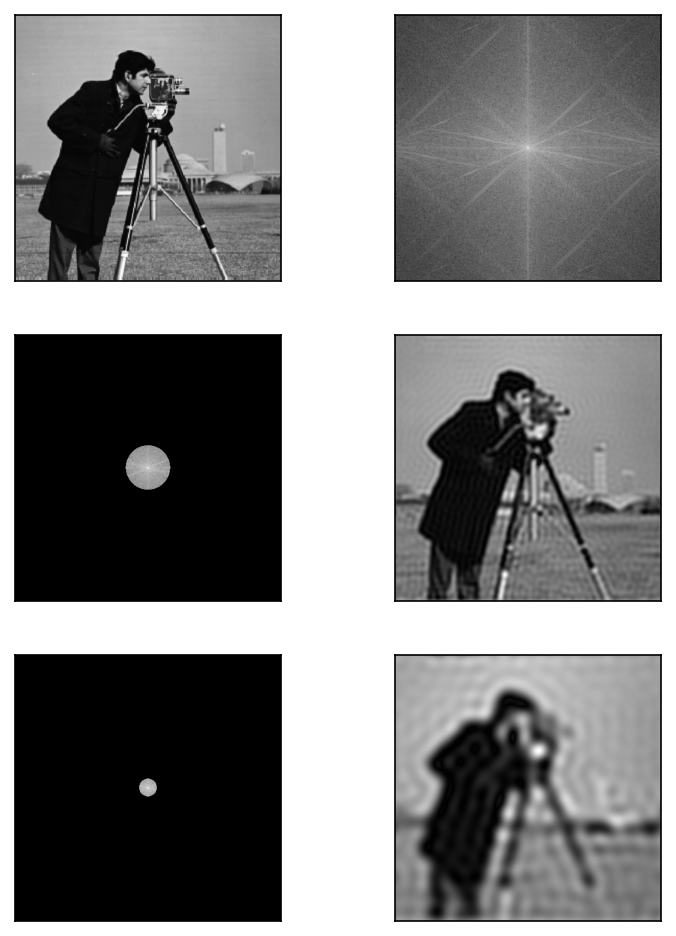

In [334]:
img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(6,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)

ax1.imshow(img1, cmap='gray')
img2 = np.fft.fftshift(np.fft.fft2(img1))
ax2.imshow(np.log(1+np.abs(img2)), cmap='gray')



X0, Y0 = np.meshgrid(np.arange(img1.shape[1]), np.arange(img1.shape[0]))    
X = X0-X0.mean()
Y = Y0-Y0.mean()
R1=min(img1.shape[0], img1.shape[1])/12.
img3=img2.copy()
img3[np.where(X**2+Y**2>R1**2)]=0

ax3.imshow(np.log(1+np.abs(img3)), cmap='gray')
img4 = np.fft.ifft2(img3)
ax4.imshow(np.abs(img4), cmap='gray')

R2=min(img1.shape[0], img1.shape[1])/30.
img5=img2.copy()
img5[np.where(X**2+Y**2>R2**2)]=0

ax5.imshow(np.log(1+np.abs(img5)), cmap='gray')
img6 = np.fft.ifft2(img5)
ax6.imshow(np.abs(img6), cmap='gray')

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

## Ideal High Pass Filtering

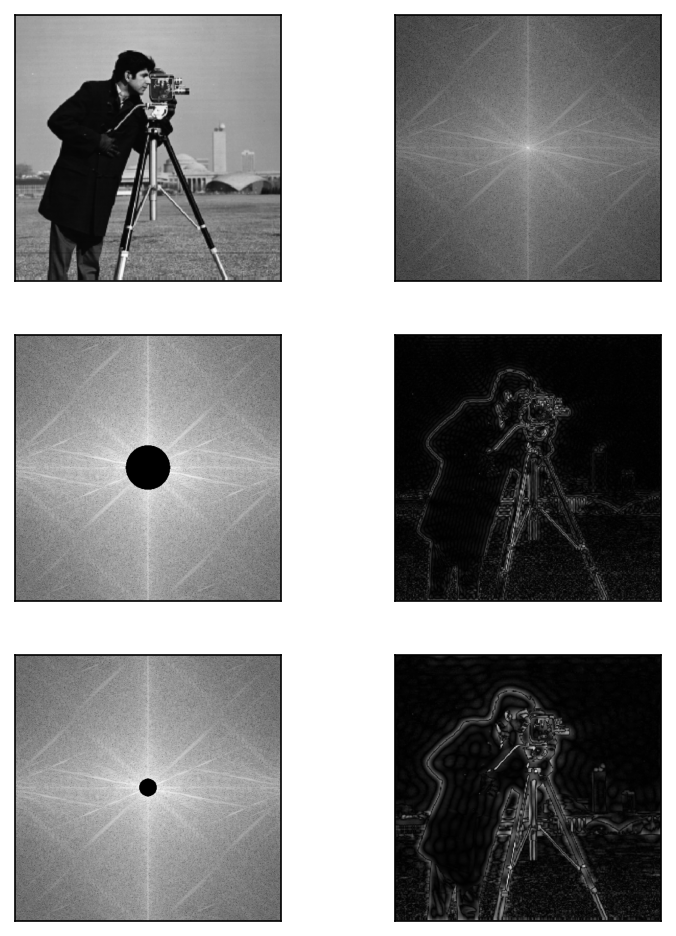

In [333]:
img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(6,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)

ax1.imshow(img1, cmap='gray')
img2 = np.fft.fftshift(np.fft.fft2(img1))
ax2.imshow(np.log(1+np.abs(img2)), cmap='gray')



X0, Y0 = np.meshgrid(np.arange(img1.shape[1]), np.arange(img1.shape[0]))    
X = X0-X0.mean()
Y = Y0-Y0.mean()
R1=min(img1.shape[0], img1.shape[1])/12.
img3=img2.copy()
img3[np.where(X**2+Y**2<R1**2)]=0

ax3.imshow(np.log(1+np.abs(img3)), cmap='gray')
img4 = np.fft.ifft2(img3)
ax4.imshow(np.abs(img4), cmap='gray')

R2=min(img1.shape[0], img1.shape[1])/30.
img5=img2.copy()
img5[np.where(X**2+Y**2<R2**2)]=0

ax5.imshow(np.log(1+np.abs(img5)), cmap='gray')
img6 = np.fft.ifft2(img5)
ax6.imshow(np.abs(img6), cmap='gray')

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

## 버터워스 필터링 (Butterworth filtering)

In [341]:
def butterworth2d(img, kind, D, n):
    """
    Realization of Butterworth filtering in 2D
    
    parameters
    ----------
    img : 2D grayscale image
    kind : 0 = highpass, 1 = lowpass
    D : diameter
    n : order
    """
    
    
    X0, Y0 = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))    
    X = X0-X0.mean()
    Y = Y0-Y0.mean()
    R = np.sqrt(X**2+Y**2)
    if kind==0:
        return 1.0/(1.+(D/R)**(2*n))
    elif kind == 1:
        return 1.0/(1.+(R/D)**(2*n))
    else :
        return None
    


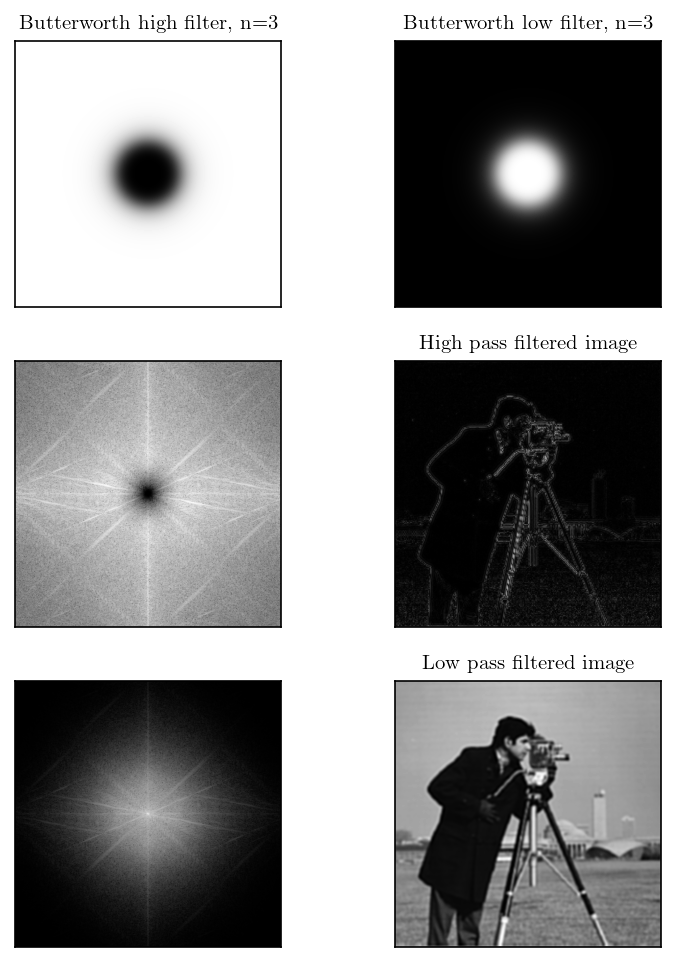

In [362]:
img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(6,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)

img_bth = butterworth2d(np.ones((img1.shape[0], img1.shape[1])), 0, 60, 3)
ax1.imshow(img_bth, cmap='gray')
ax1.set_title("Butterworth high filter, n=3", size=10)
img_btl = butterworth2d(np.ones((img1.shape[0], img1.shape[1])), 1, 60, 3)
ax2.imshow(img_btl, cmap='gray')
ax2.set_title("Butterworth low filter, n=3", size=10)

img_fft = np.fft.fftshift(np.fft.fft2(img1))



img3 = img_fft*img_bth

ax3.imshow(np.log(1+np.abs(img3)), cmap='gray')
img4 = np.fft.ifft2(img3)
ax4.imshow(np.abs(img4), cmap='gray')
ax4.set_title("High pass filtered image", size=10)

img5=mg3 = img_fft*img_btl

ax5.imshow(np.log(1+np.abs(img5)), cmap='gray')
img6 = np.fft.ifft2(img5)
ax6.imshow(np.abs(img6), cmap='gray')
ax6.set_title("Low pass filtered image", size=10)
for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

## Gaussian Filtering

In [367]:
def gaussian_filter_2d(img, kind, sigma):
    """
    Realization of Butterworth filtering in 2D
    
    parameters
    ----------
    img : 2D grayscale image
    kind : 0 = highpass, 1 = lowpass
    sigma : std of Gaussian distribution
    """
    
    
    X0, Y0 = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))    
    X = X0-X0.mean()
    Y = Y0-Y0.mean()
    R = np.sqrt(X**2+Y**2)
    if kind==0:
        return 1.-np.exp(-R**2/(2*sigma**2))
    elif kind == 1:
        return np.exp(-R**2/(2*sigma**2))
    else :
        return None
    



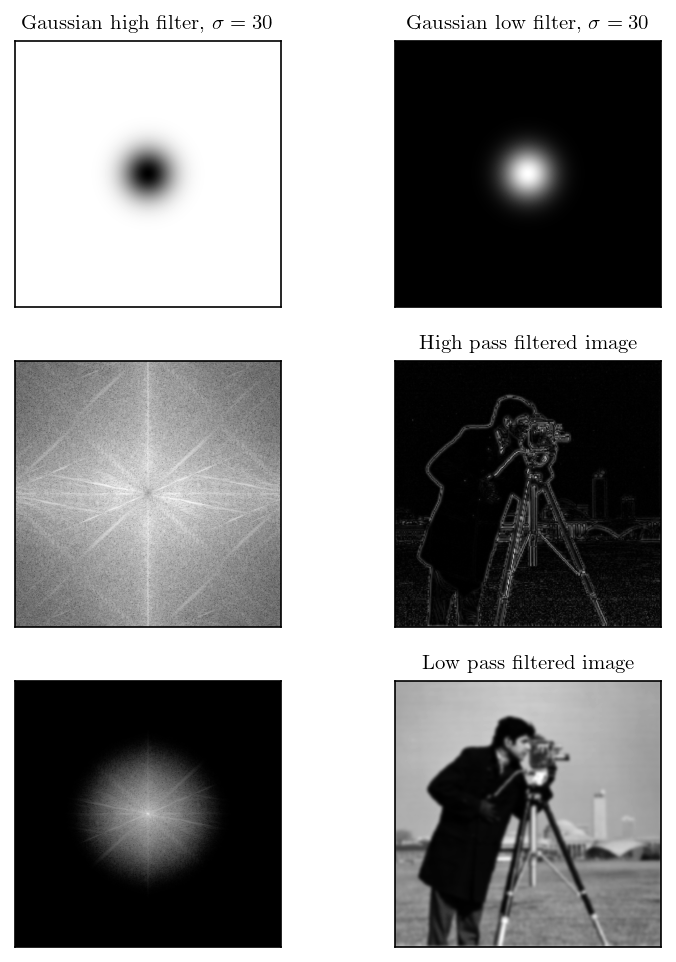

In [372]:
img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(6,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)

img_gh = gaussian_filter_2d(np.ones((img1.shape[0], img1.shape[1])), 0, 30)
ax1.imshow(img_gh, cmap='gray')
ax1.set_title("Gaussian high filter, $\\sigma=30$", size=10)
img_gl = gaussian_filter_2d(np.ones((img1.shape[0], img1.shape[1])), 1, 30)
ax2.imshow(img_gl, cmap='gray')
ax2.set_title("Gaussian low filter, $\\sigma=30$", size=10)

img_fft = np.fft.fftshift(np.fft.fft2(img1))

img3 = img_fft*img_gh

ax3.imshow(np.log(1+np.abs(img3)), cmap='gray')
img4 = np.fft.ifft2(img3)
ax4.imshow(np.abs(img4), cmap='gray')
ax4.set_title("High pass filtered image", size=10)

img5=mg3 = img_fft*img_gl

ax5.imshow(np.log(1+np.abs(img5)), cmap='gray')
img6 = np.fft.ifft2(img5)
ax6.imshow(np.abs(img6), cmap='gray')
ax6.set_title("Low pass filtered image", size=10)
for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

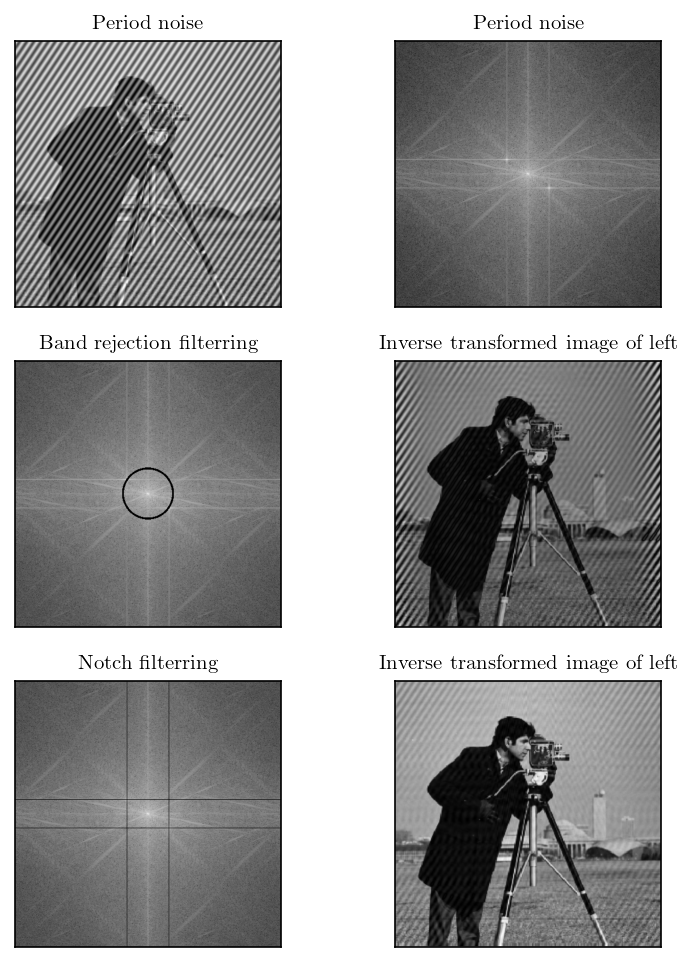

In [550]:
img0=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(6,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)
# periodic noise
X, Y = np.meshgrid(np.arange(img0.shape[1]), np.arange(img0.shape[0]))
img_pn=img1.astype(np.int64)+150*np.sin(X/2+Y/3)
ax1.imshow(img_pn, cmap='gray')
ax1.set_title("Period noise", size=10)

img_fft = np.fft.fftshift(np.fft.fft2(img_pn))
ax2.imshow(np.log(1.0+np.abs(img_fft)), cmap='gray')
ax2.set_title("Period noise", size=10)


X, Y = np.meshgrid(np.arange(img0.shape[1]), np.arange(img0.shape[0]))
X0, Y0 = X.mean(), Y.mean()
R=np.sqrt(X**2+Y**2)
img_fft_bf = np.array(img_fft, copy=True)
img_fft_bf[(((X-X0)**2+(Y-Y0)**2)<2100)& (((X-X0)**2+(Y-Y0)**2)>1800)]=0.+0.j
ax3.imshow(np.log(1.0+np.abs(img_fft_bf)), cmap='gray')
ax3.set_title("Band rejection filterring", size=10)
ax4.imshow(np.abs(np.fft.ifft2(img_fft_bf)), cmap='gray')
ax4.set_title("Inverse transformed image of left", size=10)

img_fft_nf = np.array(img_fft, copy=True)
img_fft_nf[X==197]=0
img_fft_nf[X==271]=0
img_fft_nf[Y==210]=0
img_fft_nf[Y==260]=0
ax5.imshow(np.log(1.0+np.abs(img_fft_nf)), cmap='gray')
ax5.set_title("Notch filterring", size=10)
ax6.imshow(np.abs(np.fft.ifft2(img_fft_nf)), cmap='gray')
ax6.set_title("Inverse transformed image of left", size=10)

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

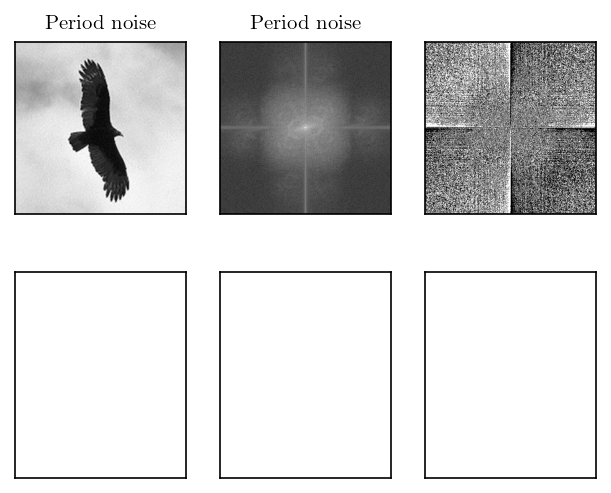

In [722]:
img0=cv2.cvtColor(cv2.imread("./img_bird_01.png"), cv2.COLOR_BGR2GRAY)
fig1 = plt.figure(figsize=(5,4), dpi= 150, facecolor='w', edgecolor='w')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(231), fig1.add_subplot(232), fig1.add_subplot(233),\
                        fig1.add_subplot(234), fig1.add_subplot(235), fig1.add_subplot(236)

ax1.imshow(img0, cmap='gray')
ax1.set_title("Period noise", size=10)

img_fft = np.fft.fftshift(np.fft.fft2(img0))
ax2.imshow(np.log(1.0+np.abs(img_fft)), cmap='gray')
ax2.set_title("Period noise", size=10)

ax3.imshow(np.arctan(img_fft.imag, img_fft.real), cmap='gray')

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [723]:
img0.shape

(431, 427)

## Periodic noise reduction - Bragg filtering

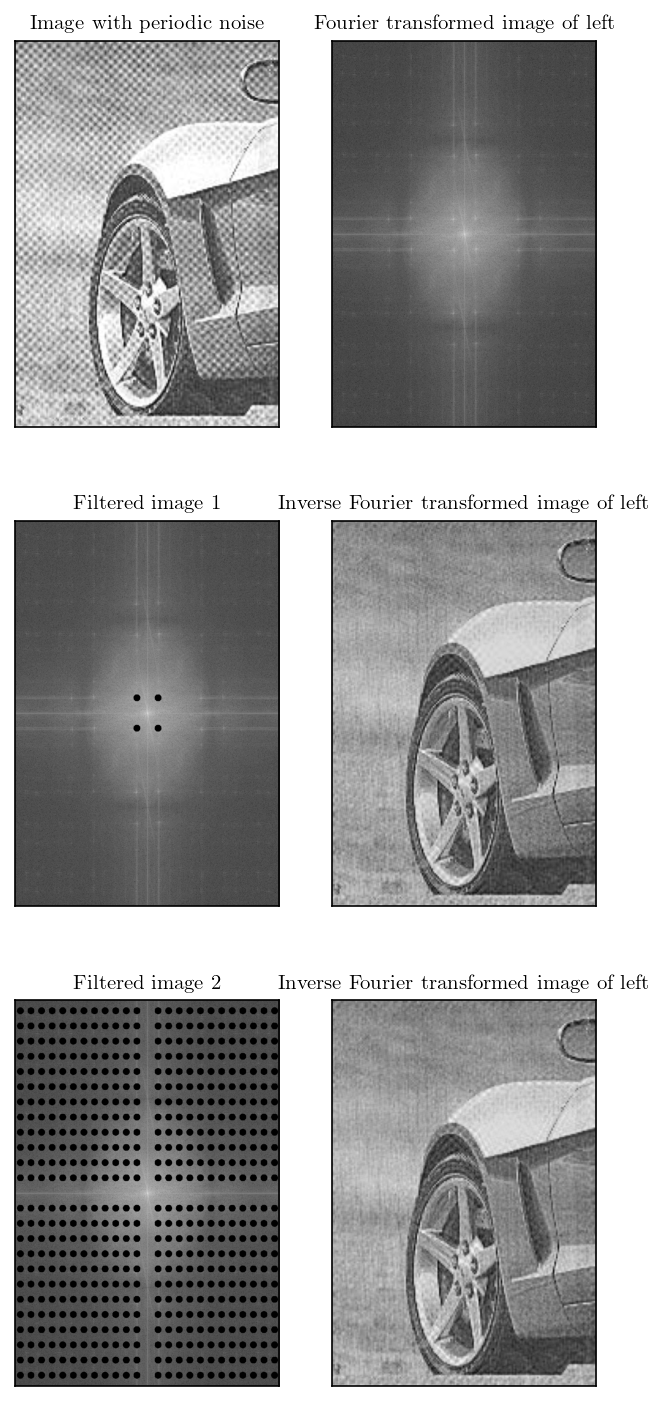

In [682]:
img0=cv2.cvtColor(cv2.imread("./img_dft_01.jpg"), cv2.COLOR_BGR2GRAY)
fig1 = plt.figure(figsize=(5,12), dpi= 150, facecolor='w', edgecolor='w')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)

X, Y = np.meshgrid(np.arange(img0.shape[1]), np.arange(img0.shape[0]))
X0, Y0 = X.mean(), Y.mean()
X, Y= X-X0, Y-Y0

R=np.sqrt(X**2+Y**2)

ax1.imshow(img0, cmap='gray')
ax1.set_title("Image with periodic noise", size=10)

img_fft = np.fft.fftshift(np.fft.fft2(img0))
ax2.imshow(np.log(1.0+np.abs(img_fft)), cmap='gray')
ax2.set_title("Fourier transformed image of left", size=10)





R0=9
X1, X2 = X0-316, -(X0-316)
Y1, Y2 = Y0-462, -(Y0-462)

img_c1=np.array(img_fft, copy=True)
Nl=1
ll = list(range(-Nl, Nl+1))
ll.remove(0)

for dd in ll:
    for ss in ll:
        img_c1[((X-dd*X1)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j
        img_c1[((X-dd*X2)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j
ax3.imshow(np.log(1.0+np.abs(img_c1)), cmap='gray')
ax3.set_title("Filtered image 1", size=10)

ax4.imshow(np.abs(np.fft.ifft2(img_c1)), cmap='gray')
ax4.set_title("Inverse Fourier transformed image of left", size=10)


img_c2=np.array(img_fft, copy=True)
Nl=12
ll = list(range(-Nl, Nl+1))
ll.remove(0)
for dd in ll:
    for ss in ll:
        img_c2[((X-dd*X1)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j
        img_c2[((X-dd*X2)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j

ax5.imshow(np.log(1.0+np.abs(img_c2)), cmap='gray')
ax5.set_title("Filtered image 2", size=10)

ax6.imshow(np.abs(np.fft.ifft2(img_c2)), cmap='gray')
ax6.set_title("Inverse Fourier transformed image of left", size=10)

img_c2=np.array(img_fft, copy=True)
for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Deblurring using inverse filtering

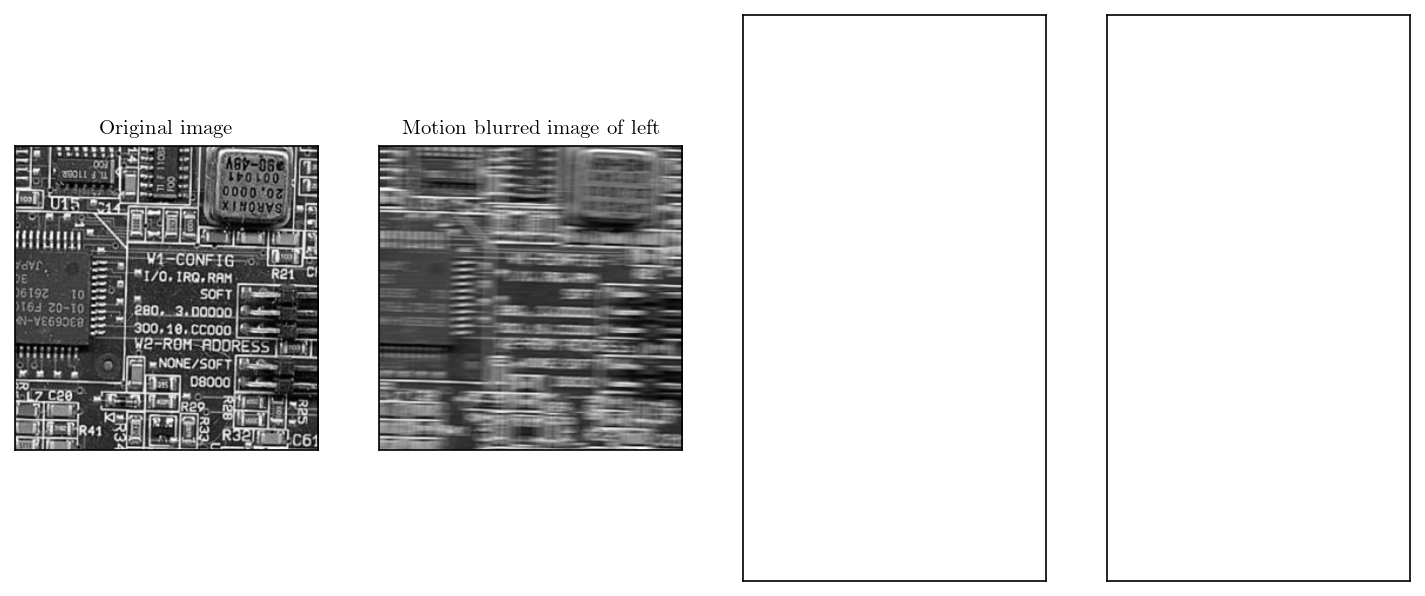

In [702]:
img0 = cv2.cvtColor(cv2.imread("./img_deblur_01.jpg"), cv2.COLOR_BGR2GRAY)
fig1 = plt.figure(figsize=(12,5), dpi= 150, facecolor='w', edgecolor='w')
ax1, ax2, ax3, ax4= fig1.add_subplot(141), fig1.add_subplot(142), fig1.add_subplot(143),\
                        fig1.add_subplot(144)

X, Y = np.meshgrid(np.arange(img0.shape[1]), np.arange(img0.shape[0]))
X0, Y0 = X.mean(), Y.mean()
X, Y= X-X0, Y-Y0

R=np.sqrt(X**2+Y**2)

ax1.imshow(img0, cmap='gray')
ax1.set_title("Original image", size=10)


size = 31

motion_blur = np.zeros((size, size))
motion_blur[int((size-1)/2), :] = np.ones(size)
motion_blur = motion_blur / size

dst = cv2.filter2D(img0, -1, motion_blur)

# img_fft = np.fft.fftshift(np.fft.fft2(img0))
ax2.imshow(dst, cmap='gray')
ax2.set_title("Motion blurred image of left", size=10)


fft_blur = np.fft.fftshift(np.fft.fft2(motion_blur))

fft_blur[np.abs(fft_blur)<0.1]=1.+0j

# R0=9
# X1, X2 = X0-316, -(X0-316)
# Y1, Y2 = Y0-462, -(Y0-462)

# img_c1=np.array(img_fft, copy=True)
# Nl=1
# ll = list(range(-Nl, Nl+1))
# ll.remove(0)

# for dd in ll:
#     for ss in ll:
#         img_c1[((X-dd*X1)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j
#         img_c1[((X-dd*X2)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j
# ax3.imshow(np.log(1.0+np.abs(img_c1)), cmap='gray')
# ax3.set_title("Filtered image 1", size=10)

# ax4.imshow(np.abs(np.fft.ifft2(img_c1)), cmap='gray')
# ax4.set_title("Inverse Fourier transformed image of left", size=10)


# img_c2=np.array(img_fft, copy=True)
# Nl=12
# ll = list(range(-Nl, Nl+1))
# ll.remove(0)
# for dd in ll:
#     for ss in ll:
#         img_c2[((X-dd*X1)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j
#         img_c2[((X-dd*X2)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j

# ax5.imshow(np.log(1.0+np.abs(img_c2)), cmap='gray')
# ax5.set_title("Filtered image 2", size=10)

# ax6.imshow(np.abs(np.fft.ifft2(img_c2)), cmap='gray')
# ax6.set_title("Inverse Fourier transformed image of left", size=10)

# img_c2=np.array(img_fft, copy=True)
for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [711]:
from scipy.signal.signaltools import wiener
filtered_img = wiener(dst, (5, 5)) 

In [714]:
a=np.arange(10)
b=a[:, np.newaxis]

In [715]:
b

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])